# Sentiment Analysis for domain-specific texts

### TASK DESCRIPTION

For this assignment, sentiment analysis was chosen to be performed on movie reviews. The data collection was done from the Rotten Tomatoes website (https://www.rottentomatoes.com). Specifically, the collected data are review comments for the most popular movies and the movies with the worst reviews, where it is observed that there are two sentiment categories: the evaluation will be either positive or negative.

---

## Field selection and dataset creation

The collection of this data is done by a script in the documents, most_popular_movies.py, which crawls the Rotten Tomatoes website for the most popular movies and exports them to a JSON file. It collects data for the first 100 pages of the site and retrieves the reviews and their sentiments based on the icon assigned by each critic. On Rotten Tomatoes, sentiments are distinguished as tomato (positive) and green splattered tomato (negative).
Similarly, there is the least_rated_movies.py script, which does the same as the previous one, but collects from fewer pages of the site and extracts reviews for the movies with the worst ratings. Thus, the files popular_reviews.json and bad_reviews.json are produced and merged into one file (all_reviews.json). The reason for this is that the data for the most popular movies is too little to yield reliable results from algorithm training.

The data collection programs require additional files to work properly, beyond the Python code. Therefore, each data collection script with scrapy has its own folder, and the two folders (one for most_popular and one for least_rates_reviews) are listed in the next cell as a Github repository page.

In [ ]:
! git clone https://github.com/mMandilara/Scrapy_rotten_tomatoes_reviews.git

Cloning into 'Scrapy_rotten_tomatoes_reviews'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 84.66 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (13/13), done.


The format of the dataset in the JSON file is as shown below, with the movie title (title), its link on the website (URL), the review (review), and the sentiment (sentiment).

In [ ]:
import pandas as pd
df = pd.read_json('all_reviews.json')

In [ ]:
print('Column names:')
df.columns.tolist()

Column names:


['title', 'url', 'review', 'sentiment']

In [ ]:
df.head()

,title,url,review,sentiment
0,10 Minutes Gone,https://www.rottentomatoes.com/m/10_minutes_gone,"""10 Minutes Gone"" is clumsy and cliché-ridden,...",NEGATIVE
1,10 Minutes Gone,https://www.rottentomatoes.com/m/10_minutes_gone,Wearing the same pained expression the actor a...,NEGATIVE
2,10 Minutes Gone,https://www.rottentomatoes.com/m/10_minutes_gone,The title of this movie proves unusually apt: ...,NEGATIVE
3,10 Minutes Gone,https://www.rottentomatoes.com/m/10_minutes_gone,"Now, if there was something winkingly camp abo...",NEGATIVE
4,10 Minutes Gone,https://www.rottentomatoes.com/m/10_minutes_gone,10 Minutes Gone starts out with most of a gang...,NEGATIVE


In [ ]:
print('Shape of dataset:')
df.shape

Shape of dataset:


(1004, 4)

In [ ]:
print('Total of reviews:')
df.title.shape

Total of reviews:


(1004,)

In [ ]:
print('Total of reviews for each movie:')
df.title.value_counts()

Total of reviews for each movie:


title
365 Days              12
Man of Steel           6
Challengers            6
Blitz                  6
Twisters               6
                      ..
Backgammon             4
Assault on VA-33       4
A Novel Romance        3
Ferry 2                2
The Little Mermaid     1
Name: count, Length: 172, dtype: int64

In [ ]:
print('How many sentiments are positive and how many are negative:')
df.sentiment.value_counts()

How many sentiments are positive and how many are negative:


sentiment
NEGATIVE    511
POSITIVE    493
Name: count, dtype: int64

In [ ]:
print('Unique values:')
df.nunique()

Unique values:


title        172
url          172
review       963
sentiment      2
dtype: int64

### Challenges in the field
Some of the challenges in sentiment analysis of reviews, especially movie reviews, are the words that may be used in the review, such as profanity, jargon. Also, often in reviews there are metaphors that can confuse the algorithm later, as well as if in the same review something positive and something negative is commented on, which can complicate the sentiment.

---

## Preprocessing and Text Analysis

In [ ]:
# Install packages
! pip install nltk pandas scikit-learn better-profanity keras tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-0.13.1-cp312-cp312-win_amd64.whl.metadata (48 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.69.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Usin

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import json
import re
import pandas as pd
from nltk.corpus import stopwords
from better_profanity import profanity
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

A dataframe is created with the reviews and sentiments.
It is observed that 1004 reviews were collected, so below there is a check to ensure there are equal positive and negative sentiments for these reviews, setting a limit of up to 500 sentiments for the dataframe. The reason for choosing up to 500 is because above it is observed that in all_reviews.json there are 511 negative and 493 positive reviews. Positive sentiments are set as one (1) and negative as -1.
It is very likely that errors will occur during the training of any model if the classes are imbalanced.

In [ ]:
# Function to create and balance data from the JSON input
def create_balanced_data(data):
    reviews = []
    sentiments = []

    sentiment_mapping = {
        "POSITIVE": 1,
        "NEGATIVE": -1
    }
    for review in data:
        if 'review' in review and 'sentiment' in review:  # Check for valid keys
            reviews.append(review['review'])
            sentiment_value = sentiment_mapping.get(review['sentiment'].upper(), None)
            if sentiment_value is not None:
                sentiments.append(sentiment_value)

    # Create a DataFrame
    df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

    top_n = 500
    positive = df[df['sentiment'] == 1].head(top_n)
    negative = df[df['sentiment'] == -1].head(top_n)

    balanced_df = pd.concat([positive, negative])

    return balanced_df

with open('all_reviews.json', encoding='utf-8') as json_file:
        data = json.load(json_file)

balanced_df = create_balanced_data(data)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

Data cleaning. In this function, stop words are removed.

In [ ]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

Removal of inappropriate words

In [ ]:
def pf_filter(sentence):
    return profanity.censor(sentence, '')

Decoding Unicode sequences to remove things like apostrophes, which appear in the data as "\u00e1"

In [ ]:
def decode_unicode(text):
    return text.encode('ascii', 'ignore').decode('utf-8')

Next, in the TextPreprocessing function, the above functions are applied, the text is cleaned, tokenized, and special characters are removed. Then, tokenization is performed on the review texts, along with stop word removal, and the sentiment of each review is tracked.
Afterwards, stemming is performed on the review texts.

In [ ]:
def TextPreProcessing(df):
    tokenized_reviews = []
    sentiments = []

    for index, review in df.iterrows():
        text = review['review']
        text = decode_unicode(text)
        text = text.lower()
        text = pf_filter(text)
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters

        # Tokenization
        tokens = word_tokenize(text)
        tokens = remove_stop_words(tokens)
        tokenized_reviews.append(tokens)

        sentiments.append(review['sentiment'])

    # Stemming
    stemmed_tokens = [[stemmer.stem(word) for word in tokens] for tokens in tokenized_reviews]
    stemmed_tokens[:10]

    df['stemmed_tokens'] = stemmed_tokens
    df['sentiment'] = sentiments

    return tokenized_reviews, sentiments, df

tokenized_reviews, sentiments, df = TextPreProcessing(balanced_df)

*Returned Values:*

*- tokenized_reviews: The list of tokenized reviews with stop words removed.*

*- sentiments: The list of sentiment values for each review.*

*- df: The updated DataFrame containing the stemmed tokens and sentiment values.*

Since the goal of the assignment is to train a model, the following are the training (train) and testing (test) data that will be used so that the model can predict the classes and be compared to the original labels to check accuracy.
The data is split into two parts, train and test, with 70% in train and 30% in test. During the split, it is preferable to have an equal distribution of classes in both the train and test data. Here, the train_test_split function from scikit-learn is used.

In [ ]:
# Train Test Split Function
def train_test(df):
    X_train, X_test, Y_train, Y_test = train_test_split(df['stemmed_tokens'],
                                                        df['sentiment'],
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=df['sentiment'])

    # Reset indices and convert to DataFrames
    # (Η επαναφορά των δεικτών εξασφαλίζει ότι κάθε υποσύνολο έχει έναν καθαρό, διαδοχικό δείκτη που ξεκινά από το 0)
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()

    return X_train, X_test, Y_train, Y_test

# Preprocess the data
tokenized_reviews, sentiments, df = TextPreProcessing(balanced_df)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test(df)

In [ ]:
print("Value counts for Train sentiments")
Y_train['sentiment'].value_counts()

Value counts for Train sentiments


sentiment
-1    350
 1    345
Name: count, dtype: int64

In [ ]:
print("Value counts for Test sentiments")
Y_test['sentiment'].value_counts()

Value counts for Test sentiments


sentiment
-1    150
 1    148
Name: count, dtype: int64

In [ ]:
X_train.head()

,index,stemmed_tokens
0,498,"[butler, schreiber, deliv, command, perform, m..."
1,39,"[andron, deriv, sound]"
2,756,"[realli, sweet, endear, holiday, romcom]"
3,971,"[baker, film, heartfelt, rush, head, extend, a..."
4,501,"[one, thing, bad, guy, shoot, one, anoth, cop,..."


As seen from the above outputs, the data is distributed proportionally for each class. The number of rows for each sentiment in train and test is printed.

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
type(Y_train)

pandas.core.frame.DataFrame

Next, vectorization will be performed using the Word2Vec method. From a brief review of similar sentiment analysis projects, it was observed that other methods such as BOW and TF-IDF treat words as separate features, rather than capturing the meaning between them. In contrast, Word2Vec captures the semantic and syntactic information of words. This method has two architectures, Continuous Bag of Words (CBOW) and Skip Gram, where the first learns word embeddings by predicting the current word based on its context. The Skip-gram model is the opposite of CBOW, learning word embeddings by predicting the context of the current word.

![rmotr](https://community.alteryx.com/t5/image/serverpage/image-id/45458iDEB69E518EBA3AD9/image-size/large?v=v2&px=999)
[Source: Word2vec for the Alteryx Community (https://community.alteryx.com/t5/Data-Science/Word2vec-for-the-Alteryx-Community/ba-p/305285)]

Below, some parameters for Word2Vec are defined, such as:
- **size:** the size of the word embeddings
- **window:** the maximum distance between a target word and words around the target word, default value = 5
- **min_count:** the minimum number of times a word must appear to be included in the model, words appearing less than this are ignored, default value = 5
- **workers:** the number of worker threads, refers to parallelism during model training, default value = 3
- **sg:** The training algorithm, either CBOW(0) or skip gram(1)

In [ ]:
# Δημιουργώντας και εκπαιδεύοντας το μοντέλο Word2Vec (με Skip-gram model, sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

In [ ]:
# Χρησιμοποιήστε τα tokens από το DataFrame για να εκπαιδεύσετε το μοντέλο Word2Vec
stemmed_tokens = pd.Series(balanced_df['stemmed_tokens']).values
w2v_model = Word2Vec(stemmed_tokens, vector_size=size, window=window, min_count=min_count, workers=workers, sg=sg)

# Save model
word2vec_model_file = 'word2vec_model_' + str(size) + '.model'
w2v_model.save(word2vec_model_file)

For convenience, so that the model does not have to be trained every time, it is saved to a file that can be loaded, as shown below.

In [ ]:
# Load the model
sg_w2v_model = Word2Vec.load(r'word2vec_model_1000.model')

In [ ]:
# Unique ID of the word
print("Index of the word 'action':")
if 'action' in sg_w2v_model.wv:
    print(sg_w2v_model.wv.key_to_index["action"])
else:
    print("Word 'action' not found in vocabulary.")

print("Total number of words in the vocabulary:", len(sg_w2v_model.wv))
print("Length of the vector generated for the word 'action':")

if 'action' in sg_w2v_model.wv:
    print(len(sg_w2v_model.wv["action"]))
else:
    print("Word 'action' not found in vocabulary.")

print("Length after averaging the word vectors for the first review:")
review_tokens = balanced_df['stemmed_tokens'].iloc[0]  # Του πρώτου review τα stemmed tokens
mean_vector = np.mean([sg_w2v_model.wv[token] for token in review_tokens if token in sg_w2v_model.wv], axis=0)

print(mean_vector.shape)

Index of the word 'action':
41
Total number of words in the vocabulary: 4269
Length of the vector generated for the word 'action':
1000
Length after averaging the word vectors for the first review:
(1000,)


### Creation of Word2Vec vectors.
Vectors are created for each movie review in the training data (X_train). The word embedding vectors are obtained using the model for each word in each review. Then, the mean is applied to all word vectors in a sentence, and this represents a sentence from the dataset. These vectors are saved to a CSV file (train_review_word2vec.csv), so that this data is readily available when needed and due to memory size.

In [ ]:
# Store the vectors for train data in a CSV file
word2vec_filename = 'train_review_word2vec.csv'

In [ ]:
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = [
            sg_w2v_model.wv[token]
            for token in row['stemmed_tokens']
            if token in sg_w2v_model.wv
        ]

        # Check if there are valid tokens, otherwise use a zero vector
        if len(model_vector) > 0:
            avg_vector = np.mean(model_vector, axis=0).tolist()
        else:
            avg_vector = [0.0] * size  # Zero vector of the desired size
        if index == 0:
            header = ",".join([f"dim_{i}" for i in range(size)])
            word2vec_file.write(header + "\n")

        line = ",".join(map(str, avg_vector))
        word2vec_file.write(line + "\n")

And the same is done for the test data.

In [ ]:
# Create vectors for the test dataset
test_vectors_filename = 'test_review_word2vec.csv'

In [ ]:
with open(test_vectors_filename, 'w+') as word2vec_file:
    for index, row in X_test.iterrows():
        model_vector = [
            sg_w2v_model.wv[token]
            for token in row['stemmed_tokens']
            if token in sg_w2v_model.wv
        ]
        # Check if valid tokens exist; otherwise, use a zero vector
        if len(model_vector) > 0:
            avg_vector = np.mean(model_vector, axis=0).tolist()
        else:
            avg_vector = [0.0] * size  # Zero vector of the desired size

        # Write header once
        if index == 0:
            header = ",".join([f"dim_{i}" for i in range(size)])
            word2vec_file.write(header + "\n")

        line = ",".join(map(str, avg_vector))
        word2vec_file.write(line + "\n")

In [ ]:
# Load train and test vectors into DataFrames
word2vec_train_df = pd.read_csv(word2vec_filename)
word2vec_test_df = pd.read_csv(test_vectors_filename)

## Machine Learning Development

By using machine learning techniques, three models are trained below that can classify the sentiments of reviews, providing them with a training model.

Once the Word2Vec vectors are ready for training, they are loaded into the dataframe and three machine learning models follow: SVM, Decision Tree, and Logistic Regression.

### Support Vector Machine (SVM)

SVM machine learning algorithm is carried out. The basic idea of this algorithm is to find the optimal hyperplane that separates the data points into different classes.

The input data is represented as trait vectors from Word2Vec embeddings. For both the training and test datasets, the tokens of each text are converted to word embeddings and, by computing the mean, are aggregated into a single vector per sample. Otherwise, if there are no valid tokens, a null vector is used.

Thus, these vectors serve as input features in the SVM model. In the code below the model named 'SVC' is run, as the sentiments in text provided as input data are not linear, they have complex relationships, for this the package from sklearn for non-linear SVM classification, SVC (Support Vector Classification) is used.

In [ ]:
import numpy as np
import itertools
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load word2vec vectors from CSV files (train and test)
word2vec_train_df = pd.read_csv('train_review_word2vec.csv')
word2vec_test_df = pd.read_csv('test_review_word2vec.csv')

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Store results
results_svm = []

# Iterate over all parameter combinations
for C, gamma, kernel in itertools.product(param_grid['C'], param_grid['gamma'], param_grid['kernel']):
    svm_clf = SVC(C=C, gamma=gamma, kernel=kernel, class_weight='balanced', random_state=42)

    # Train the model on the train data (word2vec_train_df) and the sentiment labels (Y_train)
    svm_clf.fit(word2vec_train_df, Y_train['sentiment'])

    # Predict the sentiment on the test data
    test_pred = svm_clf.predict(word2vec_test_df)

    # Compute metrics
    cm = confusion_matrix(Y_test['sentiment'], test_pred)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = accuracy_score(Y_test['sentiment'], test_pred)
    test_f1 = f1_score(Y_test['sentiment'], test_pred, average='weighted')

    # Store the results
    results_svm.append([C, gamma, kernel, test_accuracy, test_f1, tn, fp, fn, tp])

# Convert results to NumPy array for easier manipulation
results_svm = np.array(results_svm, dtype=object)

# Select best parameters based on the highest F1-score
best_idx = np.argmax(results_svm[:, 4])  # F1-score is at index 4
best_C_svm = results_svm[best_idx, 0]
best_gamma = results_svm[best_idx, 1]
best_kernel = results_svm[best_idx, 2]

# Print best parameters
print(f"Best C: {best_C_svm}, Best Gamma: {best_gamma}, Best Kernel: {best_kernel}")
print(f"Best Accuracy: {results_svm[best_idx, 3]:.4f}")
print(f"Best Weighted F1-score: {results_svm[best_idx, 4]:.4f}")
print(f"Confusion Matrix (TN, FP, FN, TP): {results_svm[best_idx, 5:]}")
print('*TN: True Negative,\n*FP: False Positive,\n*FN: False Negative,\n*TP: True Positive')


Best C: 10, Best Gamma: scale, Best Kernel: rbf
Best Accuracy: 0.6409
Best Weighted F1-score: 0.6399
Confusion Matrix (TN, FP, FN, TP): [88 62 45 103]
*TN: True Negative,
*FP: False Positive,
*FN: False Negative,
*TP: True Positive


The selection of parameters for SVM training was done with the above code, which examines the best combination of kernel, C, and gamma parameters based on the accuracy value, F1-score, and from the confusion matrix that may result, the sets of true and false values.

SVM Accuracy: 0.6409395973154363
              precision    recall  f1-score   support

          -1       0.66      0.59      0.62       150
           1       0.62      0.70      0.66       148

    accuracy                           0.64       298
   macro avg       0.64      0.64      0.64       298
weighted avg       0.64      0.64      0.64       298

Mean Squared Error (MSE): 1.436241610738255


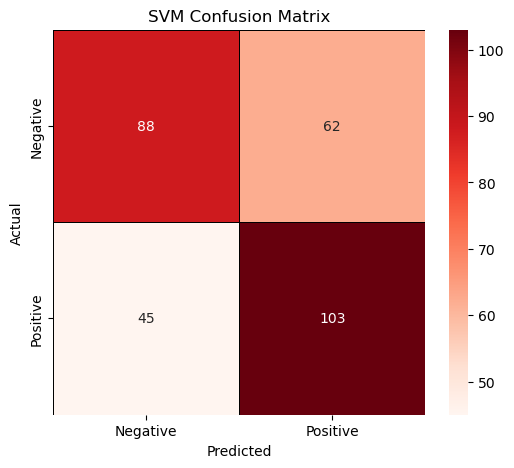

In [ ]:
#SVM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error

# Train SVM Model
svm_clf = SVC(kernel=best_kernel,
              C=np.round(best_C_svm, 2),
              gamma=best_gamma,
              class_weight='balanced',
              random_state=42 # Deterministic behavior, result will be the same for each run
              ).fit(word2vec_train_df, Y_train['sentiment'])

# Predictions
y_pred_svm = svm_clf.predict(word2vec_test_df)

# Evaluate Model
print("SVM Accuracy:", accuracy_score(Y_test['sentiment'], y_pred_svm))
print(classification_report(Y_test['sentiment'], y_pred_svm))

# Mean Squared Error (MSE)
mse = mean_squared_error(Y_test['sentiment'], y_pred_svm)
print("Mean Squared Error (MSE):", mse)

# Confusion Matrix
cm_svm = confusion_matrix(Y_test['sentiment'], y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],linecolor='black',linewidths=.7)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("SVM Confusion Matrix")
plt.show()

In the results the following metrics are shown: precision, recall και f1-score.
- Precision = $\frac{True Positives}{True Positivs + False Positives}$

- Recall = $\frac{True Positives}{True Positives + False Negatives}$

- F1 = $\frac{{Precision}\cdot{Recall}}{{Precision}+{Recall}}$

In [ ]:
%timeit svm_clf.predict(word2vec_test_df)

345 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Decision Tree

The decision tree is one of the most well-known supervised classification algorithms. Its goal is to create a training model that can be used to predict each class (in this case POSITIVE, NEGATIVE sentiment) by learning simple decision rules inferred from the input data.

As with SVM, the parameters were determined based on the documentation of the sklearn.tree library, and the best results were obtained with the following.

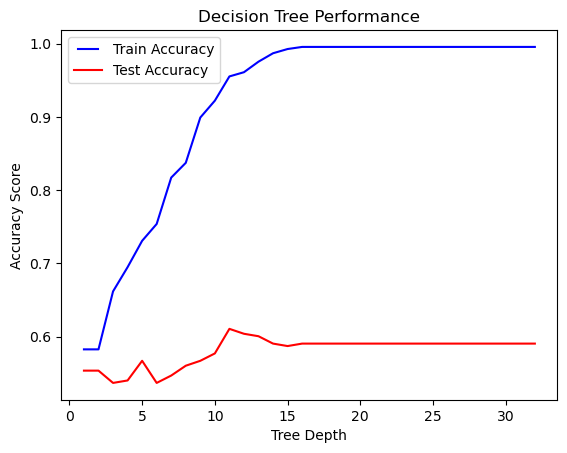

In [ ]:
# DECIDE ON MAX DEPTH VALUE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Generate depths as integers
max_depths = np.linspace(1, 32, 32, endpoint=True, dtype=int)

train_results = []
test_results = []

# Train Decision Tree Classifier
for m in max_depths:
    dt_clf = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=m,
                                    random_state=42 # Deterministic behavior, result will be the same for each run
                                    ).fit(word2vec_train_df, Y_train['sentiment'])

    # Store
    train_pred = dt_clf.predict(word2vec_train_df)
    test_pred = dt_clf.predict(word2vec_test_df)

    train_results.append(accuracy_score(Y_train['sentiment'], train_pred))
    test_results.append(accuracy_score(Y_test['sentiment'], test_pred))

# Plot Accuracy vs Tree Depth
line1, = plt.plot(max_depths, train_results, 'b', label='Train Accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label='Test Accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy Score')
plt.xlabel('Tree Depth')
plt.title('Decision Tree Performance')
plt.show()

In the above code, the value of the max_depth parameter was examined, which is the maximum depth of the tree, and the deeper the tree, the more branches it has and the more information it captures. Finally, for the criterion parameter, the method used for splitting at each node is set to 'entropy' because the decision tree is supervised classification and for supervised algorithms the best indicator is entropy.

It is observed that the value max_depth=17 is good as the accuracy from that value (approximately) and onwards reaches a threshold.
With these parameters:
- criterion = 'entropy'
- splitter = 'random'
- max_depth = 17
- random_state = 42

Decision Tree Accuracy: 0.5906040268456376
              precision    recall  f1-score   support

          -1       0.60      0.57      0.59       150
           1       0.58      0.61      0.60       148

    accuracy                           0.59       298
   macro avg       0.59      0.59      0.59       298
weighted avg       0.59      0.59      0.59       298

Mean Squared Error (MSE): 1.6375838926174497


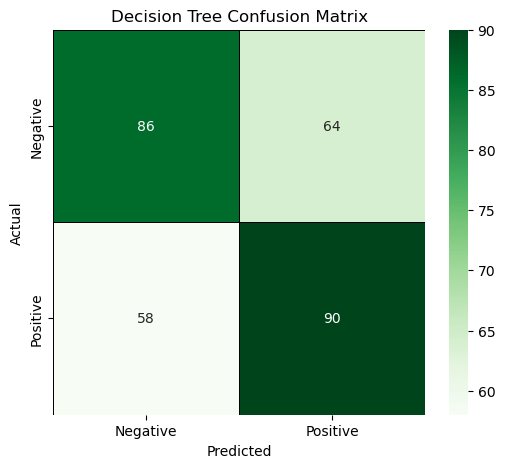

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error

# Train Decision Tree Classifier
dt_clf = DecisionTreeClassifier(criterion='entropy',
                                max_depth=17,
                                random_state=42
                                ).fit(word2vec_train_df, Y_train['sentiment'])

train_results.append(accuracy_score(Y_train['sentiment'], train_pred))
test_results.append(accuracy_score(Y_test['sentiment'], test_pred))

# Predictions
y_pred_dt = dt_clf.predict(word2vec_test_df)

# Accuracy
print("Decision Tree Accuracy:", accuracy_score(Y_test['sentiment'], y_pred_dt))
print(classification_report(Y_test['sentiment'], y_pred_dt))

# Print Mean Squared Error (MSE)
mse = mean_squared_error(Y_test['sentiment'], y_pred_dt)
print("Mean Squared Error (MSE):", mse)

# Confusion Matrix
cm_dt = confusion_matrix(Y_test['sentiment'], y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], linecolor='black', linewidths=.7)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [ ]:
%timeit dt_clf.predict(word2vec_test_df)

12.8 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Logistic Regression

Logistic regression is also one of the most well-known machine learning algorithms, supervised learning. It is used to predict a target variable based on multiple independent factors.

The result, the output of this algorithm's prediction, is categorical or discrete, i.e., it can be 'Yes' or 'No', 'True' or 'False', etc., and presents probability values ranging between 0 and 1.

Best C value (L2 penalty): 8882.68
Best Accuracy: 0.6208
Best Weighted F1-score: 0.6194
Confusion Matrix (TN, FP, FN, TP): [84 66 47 101]


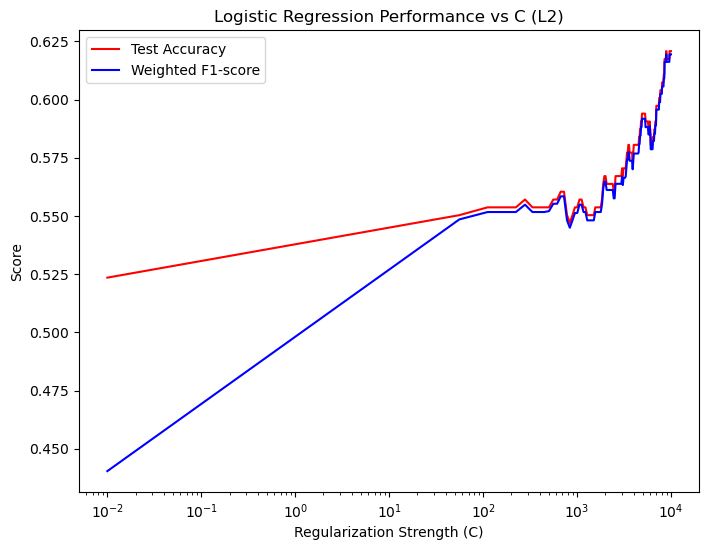


All tested C values and corresponding metrics:
 C   | Accuracy | F1-score | TN  | FP  | FN  | TP 
------------------------------------------------------------
0.01 | 0.5235 | 0.4404 | 21 | 129 | 13 | 135
55.88 | 0.5503 | 0.5485 | 73 | 77 | 57 | 91
111.74 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
167.61 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
223.47 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
279.34 | 0.5570 | 0.5548 | 73 | 77 | 55 | 93
335.21 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
391.07 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
446.94 | 0.5537 | 0.5517 | 73 | 77 | 56 | 92
502.80 | 0.5537 | 0.5521 | 74 | 76 | 57 | 91
558.67 | 0.5570 | 0.5552 | 74 | 76 | 56 | 92
614.53 | 0.5570 | 0.5552 | 74 | 76 | 56 | 92
670.40 | 0.5604 | 0.5584 | 74 | 76 | 55 | 93
726.27 | 0.5604 | 0.5584 | 74 | 76 | 55 | 93
782.13 | 0.5503 | 0.5481 | 72 | 78 | 56 | 92
838.00 | 0.5470 | 0.5449 | 72 | 78 | 57 | 91
893.86 | 0.5503 | 0.5481 | 72 | 78 | 56 | 92
949.73 | 0.5537 | 0.5513 | 72 | 78 | 55 | 93
1005.60 | 0.5537 | 0.5513 | 72 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Define C values to test
C_values = np.linspace(0.01, 10000, 180)  # 150 values from 0.1 to 1000

# Store results
results_lr = []

# Loop over different C values (using L2 penalty)
for C in C_values:
    log_reg = LogisticRegression(solver='liblinear',
                                 C=C,
                                 penalty='l2',
                                 class_weight='balanced',
                                 random_state=42
                            ).fit(word2vec_train_df, Y_train['sentiment'])

    # Predictions
    test_pred = log_reg.predict(word2vec_test_df)

    # Compute metrics
    cm = confusion_matrix(Y_test['sentiment'], test_pred)
    tn, fp, fn, tp = cm.ravel()
    test_accuracy = accuracy_score(Y_test['sentiment'], test_pred)
    test_f1 = f1_score(Y_test['sentiment'], test_pred, average='weighted')  # Weighted F1-score

    # Store results (C value, Accuracy, F1-score, Confusion matrix)
    results_lr.append((C, test_accuracy, test_f1, tn, fp, fn, tp))

# Convert results to NumPy array for easy analysis
results_lr = np.array(results_lr, dtype=object)

# Select best C value based on highest **weighted F1-score**
best_idx = np.argmax(results_lr[:, 2])  # F1-score column index = 2
best_C_lr = results_lr[best_idx, 0]

# Print best C value and corresponding scores
print(f"Best C value (L2 penalty): {best_C_lr:.2f}")
print(f"Best Accuracy: {results_lr[best_idx, 1]:.4f}")
print(f"Best Weighted F1-score: {results_lr[best_idx, 2]:.4f}")
print(f"Confusion Matrix (TN, FP, FN, TP): {results_lr[best_idx, 3:]}")

# Plot Accuracy and F1-score vs C
plt.figure(figsize=(8, 6))
plt.plot(C_values, results_lr[:, 1], 'r', label='Test Accuracy')
plt.plot(C_values, results_lr[:, 2], 'b', label='Weighted F1-score')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Score")
plt.title("Logistic Regression Performance vs C (L2)")
plt.legend()
plt.show()

# Print all results for comparison
print("\nAll tested C values and corresponding metrics:")
print(" C   | Accuracy | F1-score | TN  | FP  | FN  | TP ")
print("-" * 60)
for row in results_lr:
    print(f"{row[0]:.2f} | {row[1]:.4f} | {row[2]:.4f} | {row[3]} | {row[4]} | {row[5]} | {row[6]}")


Thus, the value C=1.94 is selected. For the solver parameter, 'liblinear' is used as it is good for small datasets and can be combined with either l1 or l2 penalty. When confirming which penalty to use, liblinear was appropriate. Ultimately, 'l2' is used, as it tends to be more stable, especially for high-dimensional data such as text embeddings. Finally, class_weight is 'balanced' because the algorithm is sensitive and, even though the number of positive and negative sentiment data is almost equal, the model may predict only the majority class.

Logistic Regression Accuracy: 0.6208053691275168
              precision    recall  f1-score   support

          -1       0.64      0.56      0.60       150
           1       0.60      0.68      0.64       148

    accuracy                           0.62       298
   macro avg       0.62      0.62      0.62       298
weighted avg       0.62      0.62      0.62       298

Mean Squared Error (MSE): 1.516778523489933


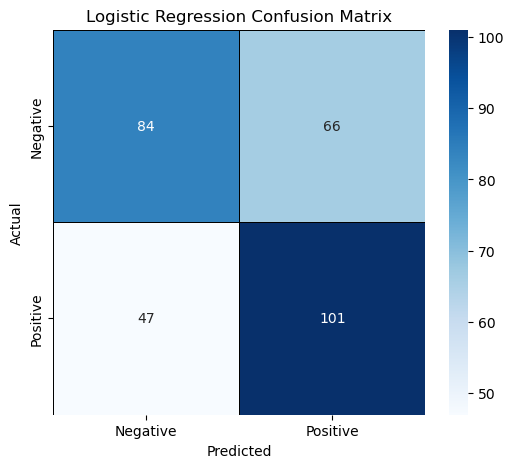

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error

# Logistic Regression Model
log_reg = LogisticRegression(solver='liblinear',
                             C= np.round(best_C_lr, 2),
                             class_weight='balanced', # Because we might have a little imbalanced classes
                             penalty='l2',                         # the model might predict only the majority class
                             random_state=1
                            ).fit(word2vec_train_df, Y_train['sentiment'])

# Predictions
y_pred_lr = log_reg.predict(word2vec_test_df)

# Evaluate Model
print("Logistic Regression Accuracy:", accuracy_score(Y_test['sentiment'], y_pred_lr))
print(classification_report(Y_test['sentiment'], y_pred_lr))

# Mean Squared Error (MSE)
mse = mean_squared_error(Y_test['sentiment'], y_pred_lr)
print("Mean Squared Error (MSE):", mse)

# Confusion Matrix
cm = confusion_matrix(Y_test['sentiment'], y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],linecolor='black',linewidths=.7)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [ ]:
%timeit log_reg.predict(word2vec_test_df)

10.3 ms ± 886 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

### Comparison of Machine Learning Algorithm Results

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

results = {}

# SVM
results["SVM"] = [
    accuracy_score(Y_test['sentiment'], y_pred_svm),
    precision_score(Y_test['sentiment'], y_pred_svm),
    recall_score(Y_test['sentiment'], y_pred_svm),
    f1_score(Y_test['sentiment'], y_pred_svm),
    mean_squared_error(Y_test['sentiment'], y_pred_svm)
]

# Decision Tree
results["Decision Tree"] = [
    accuracy_score(Y_test['sentiment'], y_pred_dt),
    precision_score(Y_test['sentiment'], y_pred_dt),
    recall_score(Y_test['sentiment'], y_pred_dt),
    f1_score(Y_test['sentiment'], y_pred_dt),
    mean_squared_error(Y_test['sentiment'], y_pred_dt)
]

# Logistic Regression
results["Logistic Regression"] = [
    accuracy_score(Y_test['sentiment'], y_pred_lr),
    precision_score(Y_test['sentiment'], y_pred_lr),
    recall_score(Y_test['sentiment'], y_pred_lr),
    f1_score(Y_test['sentiment'], y_pred_lr),
    mean_squared_error(Y_test['sentiment'], y_pred_lr)
]

# Print Comparison Table
df_results = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score", "MSE"]).T
print("\nComparison of Models:\n")
print(df_results)


Comparison of Models:

                     Accuracy  Precision    Recall  F1-score       MSE
SVM                  0.640940   0.624242  0.695946  0.658147  1.436242
Decision Tree        0.590604   0.584416  0.608108  0.596026  1.637584
Logistic Regression  0.620805   0.604790  0.682432  0.641270  1.516779


## Deep Learning Model Development

Deep learning models, especially neural networks, can perceive complex patterns and associations within the data and thus achieve better accuracy than classic machine learning models.

Deep learning models are not supervised methods, like the previous ones. An additional positive feature is that they can adapt to different types of data and conditions, making them flexible and useful for various fields.

Below, two deep learning methods will be examined: Convolutional Neural Network (CNN) and Bidirectional Long Short-Term Memory Network (BiLSTM).

### Convolutional Neural Network (CNN)

The way CNN works is by performing convolution, then pooling, convolution again, pooling, leading to a fully connected layer and ending at the output.

With convolution, the initial data is taken and a feature map is created from it.

Pooling is down-sampling, where a region is selected and then the maximum value in that region is taken. The fully connected layers are typical neural networks where all nodes are fully connected. The convolutional layers are not fully connected like a traditional neural network.

Before starting model training, some suitable parameter values need to be found for the model from the tensorflow keras library, such as vocabulary size and max sequence length.

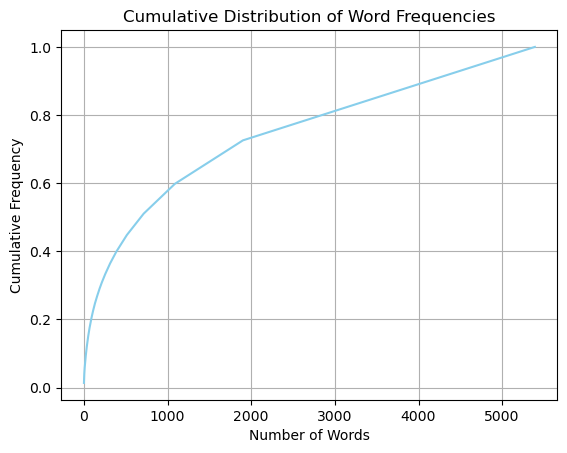

Recommended vocab_size (covers 95% of the vocabulary): 4756


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

# Υπολογισμός των lengths των tokenized reviews
review_lengths = [len(review) for review in tokenized_reviews]

# Flatten την λίστα των tokenized reviews
all_tokens = [token for review in tokenized_reviews for token in review]

# Συχνότητα λέξεων
word_freqs = Counter(all_tokens)
total_words = sum(word_freqs.values())

# Ταξινόμηση λέξεων με βάση την συχνότητά τους
sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)

# Υπολογισμός αθροιστικής συχνότητας
cumulative_freqs = np.cumsum([freq for word, freq in sorted_word_freqs]) / total_words

# Plot τη αθροιστική κατανομή των συχνοτήτων των λέξεων
plt.plot(cumulative_freqs, color='skyblue')
plt.title('Cumulative Distribution of Word Frequencies')
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency')
plt.grid(True)
plt.show()

# Εύρεση του vocab_size που καλύπτει το 95% του λεξιλογίου, οι περισσότερες σημαντικές λέξεις παραμένουν ενώ οι πολύ σπάνιες αγνοούνται.
vocab_size = np.searchsorted(cumulative_freqs, 0.95) + 1
print(f"Recommended vocab_size (covers 95% of the vocabulary): {vocab_size}")

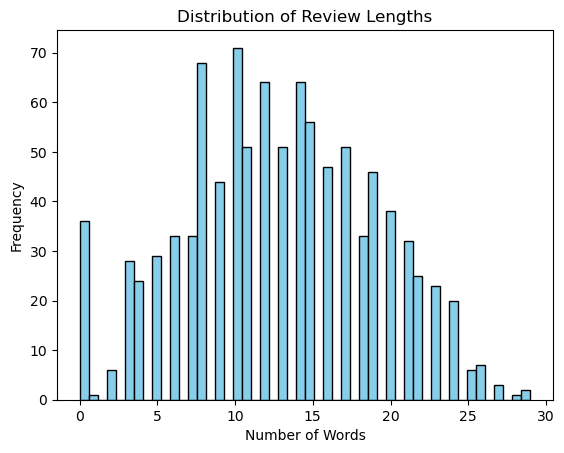

Recommended max_sequence_length (95th percentile): 23.0


In [ ]:
import matplotlib.pyplot as plt

# Plot την κατανομή του μήκους των reviews
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Εύρεση του 95ου εκατοστημορίου μήκους για να καθοριστεί ένα καλό max_sequence_length (perfect for spotting short-term trends and anomalies)
max_sequence_length = np.percentile(review_lengths, 95)
print(f"Recommended max_sequence_length (95th percentile): {max_sequence_length}")

Once the values of two parameters have been found, the data to be used in the deep learning model are defined. In X and Y train and test, some processing is needed to use them in the model. For example, converting the training and test data from dataframe to numpy arrays.

This is because the libraries used, Tensorflow and Keras, expect the input data to be in numpy array format.

Then, using 'StandardScaler', normalization of word vectors is performed, ensuring that each feature has a mean of zero and a standard deviation of one, which in turn ensures that there will be no overfitting or overflows.

Next, the sequences are padded to ensure that all have the same length (max_sequence_length), by adding padding at the end of the sequences.

Then, the sentiment labels are encoded with values 0 for negative sentiment and 1 for positive sentiment, using the LabelEncoder class. This allows the labels to be represented in a form understandable by neural networks.

Afterwards, an additional dimension is added to the input data using np.expand_dims. This is necessary because the Conv1D layers of the model expect the input data to have a specific shape (sequence length, number of channels).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
x_train_cnn = np.array(word2vec_train_df)
x_test_cnn = np.array(word2vec_test_df)

# Normalize word vectors
scaler = StandardScaler()
x_train_cnn = scaler.fit_transform(x_train_cnn)
x_test_cnn = scaler.transform(x_test_cnn)

# Pad sequences
x_train_cnn = pad_sequences(x_train_cnn, maxlen=max_sequence_length, padding='post')
x_test_cnn = pad_sequences(x_test_cnn, maxlen=max_sequence_length, padding='post')

# Encode labels
le = LabelEncoder()
y_train_cnn = le.fit_transform(np.where(Y_train['sentiment'] == -1, 0, Y_train['sentiment']))
y_test_cnn = le.transform(np.where(Y_test['sentiment'] == -1, 0, Y_test['sentiment']))

# Expand dimensions
x_train_cnn = np.expand_dims(x_train_cnn, axis=-1)
x_test_cnn = np.expand_dims(x_test_cnn, axis=-1)

Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14

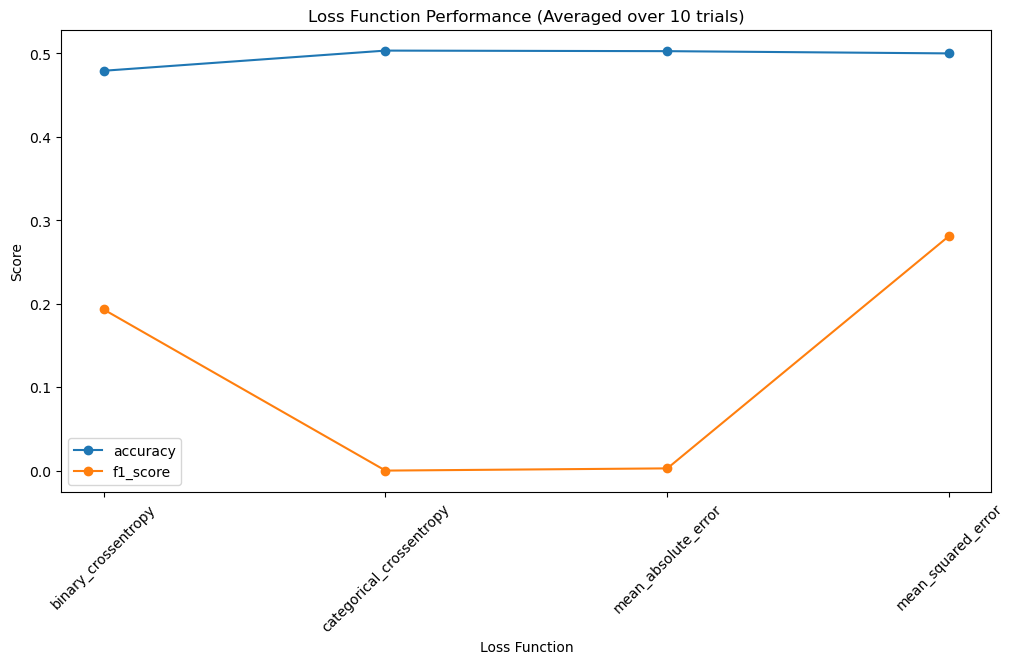

Training final model with best loss function: mean_squared_error
Epoch 1/20
22/22 - 2s - 97ms/step - accuracy: 0.5094 - loss: 0.2480 - val_accuracy: 0.5470 - val_loss: 0.2462
Epoch 2/20
22/22 - 0s - 14ms/step - accuracy: 0.5468 - loss: 0.2446 - val_accuracy: 0.5235 - val_loss: 0.2441
Epoch 3/20
22/22 - 0s - 16ms/step - accuracy: 0.5655 - loss: 0.2435 - val_accuracy: 0.5336 - val_loss: 0.2431
Epoch 4/20
22/22 - 0s - 11ms/step - accuracy: 0.5655 - loss: 0.2423 - val_accuracy: 0.5537 - val_loss: 0.2420
Epoch 5/20
22/22 - 0s - 11ms/step - accuracy: 0.5698 - loss: 0.2422 - val_accuracy: 0.6174 - val_loss: 0.2416
Epoch 6/20
22/22 - 0s - 12ms/step - accuracy: 0.5770 - loss: 0.2393 - val_accuracy: 0.5738 - val_loss: 0.2407
Epoch 7/20
22/22 - 0s - 10ms/step - accuracy: 0.5683 - loss: 0.2388 - val_accuracy: 0.5805 - val_loss: 0.2402
Epoch 8/20
22/22 - 0s - 15ms/step - accuracy: 0.6072 - loss: 0.2378 - val_accuracy: 0.5906 - val_loss: 0.2394
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


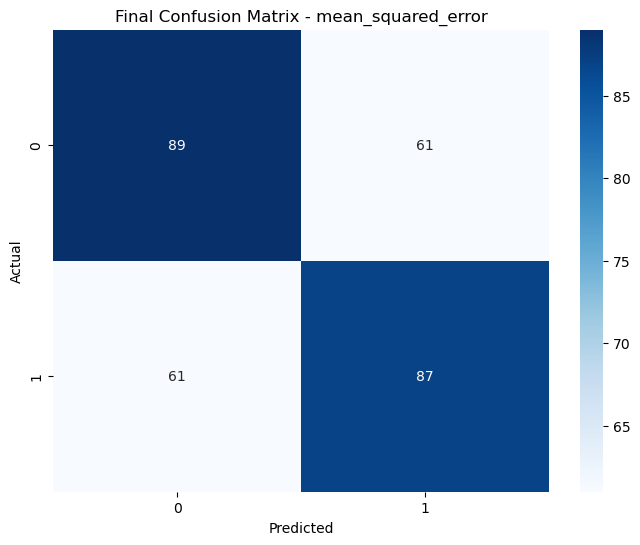

In [ ]:
# Define loss functions to test
loss_functions = [
    "binary_crossentropy", "categorical_crossentropy",
    "mean_absolute_error", "mean_squared_error",
]

# Iterate through loss functions multiple times
num_trials = 5
results = {loss_function: {'accuracy': [], 'f1_score': []} for loss_function in loss_functions}
for _ in range(num_trials):
    for loss_function in loss_functions:
        print(f"Testing loss function: {loss_function}")

        # Build Model
        model = Sequential([
            Conv1D(128, 5, activation='relu', input_shape=(max_sequence_length, 1)),
            MaxPooling1D(pool_size=2),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='relu')
        ])

        # Compile the Model
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

        # Train the Model (Change epochs to a higher value, like 50)
        model.fit(
            x_train_cnn,
            y_train_cnn,
            epochs=50,  # Increased number of epochs for experimentation
            batch_size=32,
            validation_data=(x_test_cnn, y_test_cnn),
            callbacks=[early_stopping],
            verbose=0  # Suppress output for clarity
        )

        # Evaluate the model
        loss, accuracy = model.evaluate(x_test_cnn, y_test_cnn, verbose=0)
        y_pred = model.predict(x_test_cnn)
        y_pred = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_test_cnn, y_pred)

        results[loss_function]['accuracy'].append(accuracy)
        results[loss_function]['f1_score'].append(f1)

# Compute average scores for each loss function
avg_results = {lf: {'accuracy': np.mean(results[lf]['accuracy']), 'f1_score': np.mean(results[lf]['f1_score'])} for lf in loss_functions}

# Find the best loss function
best_loss_function_lstm = max(avg_results, key=lambda k: avg_results[k]['f1_score'])
print(f"Best loss function based on average F1-score: {best_loss_function_lstm}")

# Plot results
plt.figure(figsize=(12, 6))
metrics = ['accuracy', 'f1_score']
for metric in metrics:
    values = [avg_results[lf][metric] for lf in loss_functions]
    plt.plot(loss_functions, values, marker='o', label=metric)
plt.xticks(rotation=45)
plt.xlabel("Loss Function")
plt.ylabel("Score")
plt.title("Loss Function Performance (Averaged over 10 trials)")
plt.legend()
plt.show()

# Train and evaluate model using best loss function
print(f"Training final model with best loss function: {best_loss_function_lstm}")
final_model = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=(max_sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])
final_model.compile(loss=best_loss_function_lstm, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the final model with more epochs
history = final_model.fit(
    x_train_cnn,
    y_train_cnn,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_cnn, y_test_cnn),
    callbacks=[early_stopping],
    verbose=2
)

# Predict on test data
y_pred_cnn = final_model.predict(x_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

# Confusion matrix for the best loss function
cm = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Final Confusion Matrix - {best_loss_function_lstm}')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4860 - loss: 0.3174
Test Accuracy: 0.4899328947067261


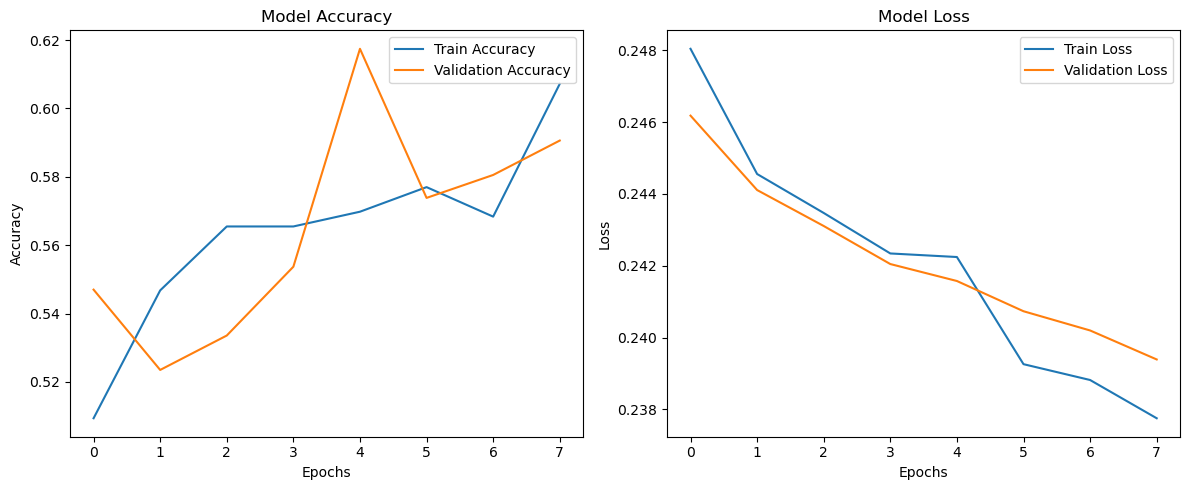

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Evaluate the model
loss, accuracy = model.evaluate(x_test_cnn, y_test_cnn)
print(f"Test Accuracy: {accuracy}")

# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()

# Plot Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Model Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

We look more at the validation values and want (in both types of results) the accuracy to increase and the loss to decrease. The difference between the blue and orange lines in the above diagram is that the training line (blue) shows if the model is learning, while the validation line (orange) shows if the model is able to generalize well to new data. And when there is no change after a certain value in a graph, it indicates that the model has reached its maximum ability to learn from the training data.

---

### Bidirectional Long Short-Term Memory (BiLSTM) network

BiLSTM (Bidirectional Long Short-Term Memory) is a higher-order version of the well-known LSTM model, which receives input from sequences both forwards and backwards. Using two LSTM layers - one analyzes the sequence from start to end, the other from end to start - BiLSTM captures both the past and the future for each time step.

Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Testing loss function: binary_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Testing loss function: categorical_crossentropy
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Testing loss function: mean_absolute_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Testing loss function: mean_squared_error
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 10

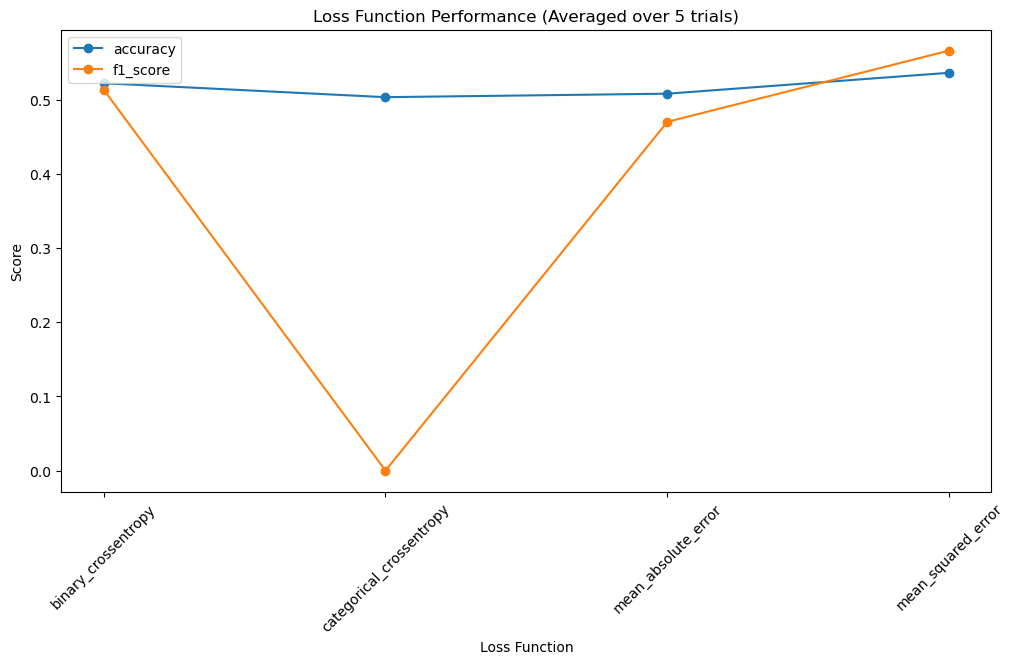

Training final model with best loss function: mean_squared_error
Epoch 1/20
22/22 - 16s - 724ms/step - accuracy: 0.5137 - loss: 0.2497 - val_accuracy: 0.5101 - val_loss: 0.2496
Epoch 2/20
22/22 - 1s - 65ms/step - accuracy: 0.5324 - loss: 0.2494 - val_accuracy: 0.5235 - val_loss: 0.2493
Epoch 3/20
22/22 - 1s - 60ms/step - accuracy: 0.5295 - loss: 0.2491 - val_accuracy: 0.5235 - val_loss: 0.2488
Epoch 4/20
22/22 - 2s - 86ms/step - accuracy: 0.5122 - loss: 0.2487 - val_accuracy: 0.5336 - val_loss: 0.2483
Epoch 5/20
22/22 - 3s - 137ms/step - accuracy: 0.4978 - loss: 0.2482 - val_accuracy: 0.5034 - val_loss: 0.2478
Epoch 6/20
22/22 - 2s - 78ms/step - accuracy: 0.5165 - loss: 0.2482 - val_accuracy: 0.5235 - val_loss: 0.2473
Epoch 7/20
22/22 - 1s - 67ms/step - accuracy: 0.5237 - loss: 0.2472 - val_accuracy: 0.5336 - val_loss: 0.2467
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


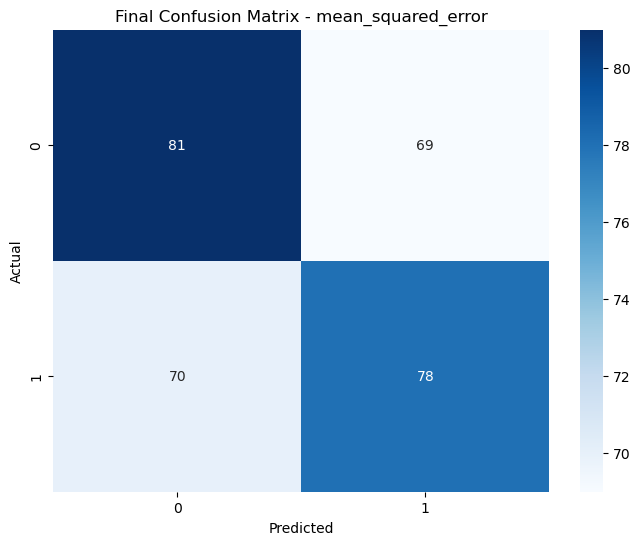

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data (assumed to already be in word2vec format)
x_train_bilstm = np.array(word2vec_train_df)
x_test_bilstm = np.array(word2vec_test_df)

# Normalize word vectors
scaler = StandardScaler()
x_train_bilstm = scaler.fit_transform(x_train_bilstm)
x_test_bilstm = scaler.transform(x_test_bilstm)

# Pad sequences (same as CNN model)
max_sequence_length = int(np.percentile(review_lengths, 95))
x_train_bilstm = pad_sequences(x_train_bilstm, maxlen=max_sequence_length, padding='post')
x_test_bilstm = pad_sequences(x_test_bilstm, maxlen=max_sequence_length, padding='post')

# Encode labels
le = LabelEncoder()
y_train_bilstm = le.fit_transform(np.where(Y_train['sentiment'] == -1, 0, Y_train['sentiment']))
y_test_bilstm = le.transform(np.where(Y_test['sentiment'] == -1, 0, Y_test['sentiment']))

# Define loss functions to test
loss_functions = [
    "binary_crossentropy", "categorical_crossentropy",
    "mean_absolute_error", "mean_squared_error",
]

# Iterate through loss functions multiple times
num_trials = 5
results = {loss_function: {'accuracy': [], 'f1_score': []} for loss_function in loss_functions}
for _ in range(num_trials):
    for loss_function in loss_functions:
        print(f"Testing loss function: {loss_function}")

        # Build Model (BiLSTM)
        model = Sequential([
            Bidirectional(LSTM(128, return_sequences=True), input_shape=(max_sequence_length, 1)),
            LSTM(128),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
        ])

        # Compile the Model
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

        # Train the Model
        model.fit(
            x_train_bilstm,
            y_train_bilstm,
            epochs=20,  # Increased number of epochs for experimentation
            batch_size=32,
            validation_data=(x_test_bilstm, y_test_bilstm),
            callbacks=[early_stopping],
            verbose=0  # Suppress output for clarity
        )

        # Evaluate the model
        loss, accuracy = model.evaluate(x_test_bilstm, y_test_bilstm, verbose=0)
        y_pred = model.predict(x_test_bilstm)
        y_pred = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_test_bilstm, y_pred)

        results[loss_function]['accuracy'].append(accuracy)
        results[loss_function]['f1_score'].append(f1)

# Compute average scores for each loss function
avg_results = {lf: {'accuracy': np.mean(results[lf]['accuracy']), 'f1_score': np.mean(results[lf]['f1_score'])} for lf in loss_functions}

# Find the best loss function
best_loss_function_bilstm = max(avg_results, key=lambda k: avg_results[k]['f1_score'])
print(f"Best loss function based on average F1-score: {best_loss_function_bilstm}")

# Plot results
plt.figure(figsize=(12, 6))
metrics = ['accuracy', 'f1_score']
for metric in metrics:
    values = [avg_results[lf][metric] for lf in loss_functions]
    plt.plot(loss_functions, values, marker='o', label=metric)
plt.xticks(rotation=45)
plt.xlabel("Loss Function")
plt.ylabel("Score")
plt.title("Loss Function Performance (Averaged over 5 trials)")
plt.legend()
plt.show()

# Train and evaluate model using best loss function
print(f"Training final model with best loss function: {best_loss_function_bilstm}")
final_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(max_sequence_length, 1)),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])
final_model.compile(loss=best_loss_function_bilstm, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the final model
history = final_model.fit(
    x_train_bilstm,
    y_train_bilstm,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_bilstm, y_test_bilstm),
    callbacks=[early_stopping],
    verbose=2
)

# Predict on test data
y_pred_bilstm = final_model.predict(x_test_bilstm)
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)

# Confusion matrix for the best loss function
cm = confusion_matrix(y_test_bilstm, y_pred_bilstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Final Confusion Matrix - {best_loss_function_bilstm}')
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5555 - loss: 0.2403
Test Accuracy: 0.5604026913642883


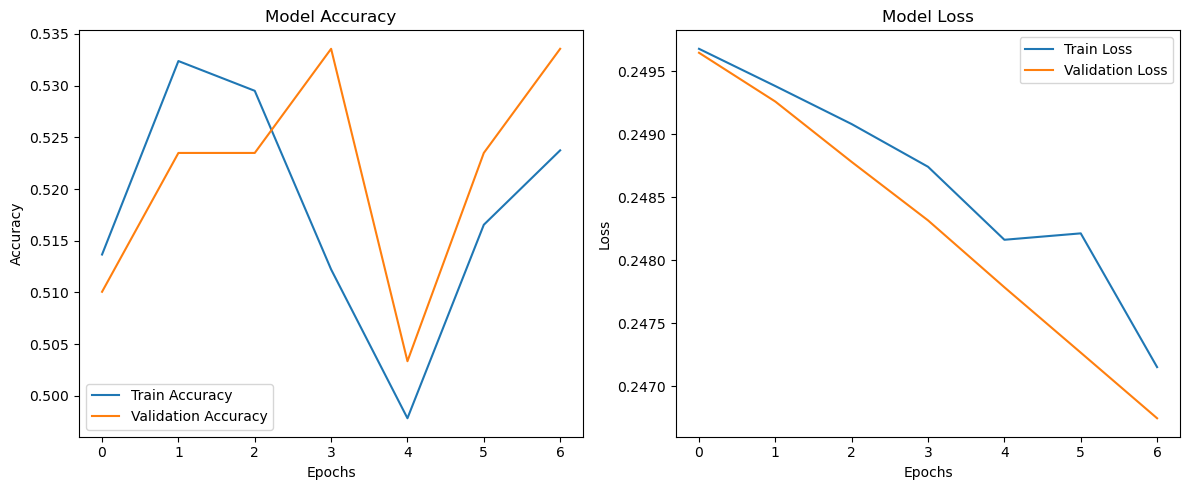

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential

# Evaluate the model
loss, accuracy = model.evaluate(x_test_bilstm, y_test_bilstm)
print(f"Test Accuracy: {accuracy}")

# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()

# Plot Loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Model Loss')
ax[1].legend()

plt.tight_layout()
plt.show()